In [12]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from numba import njit
from sympy import Matrix


# ============================================================
# NUMBA-ACCELERATED SSA CORE (WITH FULL TRAJECTORY TRACKING)
# ============================================================

@njit
def ssa_core(
    SM,
    current_pops,
    rates_list,
    current_pops_index,
    final_time,
    num_internal_species
):
    t = 0.0
    T = final_time

    n_species = len(current_pops)
    n_reactions = SM.shape[1]

    # ---- Preallocate storage ----
    max_steps = 1_000_000   # Increase if needed
    time_history = np.zeros(max_steps)
    pop_history = np.zeros((max_steps, n_species))

    # Store initial state
    step_counter = 0
    time_history[0] = t
    pop_history[0, :] = current_pops

    while t < T:

        # ---- Propensity ----
        propensity_vector = np.zeros(n_reactions)

        for a in range(n_reactions):
            product_of_counts = 1.0
            for idx in current_pops_index[a]:
                product_of_counts *= current_pops[idx]
            propensity_vector[a] = product_of_counts * rates_list[a]

        a0 = np.sum(propensity_vector)

        if a0 == 0.0:
            break

        r1 = np.random.rand()
        r2 = np.random.rand()

        tau = -math.log(r1) / a0
        target_value = r2 * a0

        cumulative = 0.0
        reaction_chosen = 0

        for n in range(n_reactions):
            cumulative += propensity_vector[n]
            if target_value <= cumulative:
                reaction_chosen = n
                break

        # ---- Update ----
        t += tau

        for m in range(num_internal_species):
            current_pops[m] += SM[m, reaction_chosen]

        # ---- Store state ----
        step_counter += 1

        if step_counter >= max_steps:
            break

        time_history[step_counter] = t
        pop_history[step_counter, :] = current_pops

    # Trim arrays to actual size
    time_history = time_history[:step_counter + 1]
    pop_history = pop_history[:step_counter + 1, :]

    return time_history, pop_history, current_pops


# ============================================================
# CLASS
# ============================================================

class RunSSA:

    def __init__(self, module_for_simulating, initial_counts, rates, simulation_length):

        self.stoich_matrix = module_for_simulating.stoich_matrix
        self.species_names = module_for_simulating.species_names
        self.current_pops = initial_counts
        self.rates_list = rates
        self.final_time = simulation_length
        self.num_internal_species = module_for_simulating.num_internal_species

        self.SM_with_reverse_stoichiometry = self.create_SM_with_reverse_stoichiometry()
        self.current_pops_index = self.determine_consumed_species_in_each_reaction()


    def create_SM_with_reverse_stoichiometry(self):

        SM = []

        for p in range(self.stoich_matrix.cols):
            SM.append(self.stoich_matrix[:, p])
            SM.append(-self.stoich_matrix[:, p])

        self.SM_with_reverse_stoichiometry = Matrix.hstack(*SM)
        return self.SM_with_reverse_stoichiometry


    def determine_consumed_species_in_each_reaction(self):

        self.current_pops_index = []

        for l in range(self.SM_with_reverse_stoichiometry.cols):

            reaction = self.SM_with_reverse_stoichiometry[:, l]
            current_reaction_indexes = []

            for p in range(len(reaction)):
                if reaction[p] < 0:
                    current_reaction_indexes.append(p)

            self.current_pops_index.append(current_reaction_indexes)

        return self.current_pops_index


    def run_SSA_and_plot_counts(self):

        SM_np = np.array(self.SM_with_reverse_stoichiometry).astype(np.float64)
        current_pops_np = np.array(self.current_pops, dtype=np.float64)
        rates_np = np.array(self.rates_list, dtype=np.float64)

        current_pops_index_np = [
            np.array(lst, dtype=np.int64) for lst in self.current_pops_index
        ]

        start = time.time()

        time_history, pop_history, final_pops = ssa_core(
            SM_np,
            current_pops_np,
            rates_np,
            current_pops_index_np,
            self.final_time,
            self.num_internal_species
        )

        end = time.time()

        self.current_pops = final_pops.tolist()
        self.time_history = time_history
        self.pop_history = pop_history

        # ---- Print final populations ----
        for m in range(self.num_internal_species):
            print(f'Final {self.species_names[m]}: {self.current_pops[m]}')

        print(f'Total Loop time: {end - start}')

        # ---- Plot counts vs time ----
        plt.figure(figsize=(8,5))

        for m in range(self.num_internal_species):
            plt.step(
                self.time_history,
                self.pop_history[:, m],
                where="post",
                label=self.species_names[m]
            )

        plt.xlabel("Time")
        plt.ylabel("Molecule count")
        plt.title("Gillespie SSA Simulation")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [2]:
# all imports

import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
#init_printing(use_unicode=True)
warnings.simplefilter('ignore')
import re
from sympy import *
import sympy
init_printing()

class ModuleProperties:

    def __init__(self, stoich_matrix, num_internal_species, species_names):
        self.stoich_matrix = sympy.Matrix(stoich_matrix)
        self.num_internal_species = num_internal_species
        self.num_external_species = self.stoich_matrix.shape[0] - num_internal_species
        self.num_species = self.stoich_matrix.shape[0]
        self.num_reactions = self.stoich_matrix.shape[1]
        self.species_labels = {i: item for i, item in enumerate(species_names)}
        self.species_names = species_names
        self.internal_stoich_matrix = self.stoich_matrix[0:self.num_internal_species, :]
        self.external_stoich_matrix = self.stoich_matrix[self.num_internal_species: len(self.stoich_matrix), :]


        # LABELLING FOR SPECIES, FORCES, EDGE CURRENTS, CHEMICAL POTENTIALS

        #self.species_labels = []

        self.chemical_potentials = []
     

        for n in range(self.num_species):
            
            #species_symbol = species_names[n]
            species_symbol = symbols(species_names[n])
            #self.species_labels.append(species_symbol)

            chem_pot = symbols(f"\mu_{species_symbol}")
            self.chemical_potentials.append(chem_pot)
            

        self.chemical_potentials_vector = Matrix(self.chemical_potentials).T  # make a vector out of the labelled chemical potentials
        
        # LABELS FOR ALL RESISTANCES AND REACTIONS

        
        resistances = [] # define list to hold reaction labels
        edge_currents_j = [] # to hold the js
        forces = [] # to hold reaction level forces

        for n in range(self.num_reactions): # loop over each reaction
            nth_resistance = symbols(f"r{n+1}") # assign name of nth resistance
            resistances.append(nth_resistance) # add to list of resistance

            nth_edge_currents_j = symbols(f"j{n+1}") # assign name of nth edge current
            edge_currents_j.append(nth_edge_currents_j) # add to list of currents

            reaction_vector = -1* self.stoich_matrix[:,n] # take the column of SM that corresponds to nth reaction
            
            forces.append(self.chemical_potentials_vector*reaction_vector) # use reaction vector *-1  in SM to create forces in terms of chem potentials
        
        
        self.force_vector = Matrix(forces) # create a vector of reaction level forces
        self.edge_currents_vector = Matrix(edge_currents_j) # make a vector out of the js


        # reaction resistance in terms of r = f/j

        reaction_level_res = [] # to hold reaction level resistances

        for n in range(self.num_reactions): # loop over each reaction
            symbolic_resistance = self.force_vector[n] / self.edge_currents_vector[n]

            reaction_level_res.append(symbolic_resistance)

        self.reaction_level_resistances = reaction_level_res # output reaction level resistances in terms of r = f/j

        self.kinetic_form_resistance_matrix = Matrix.diag(reaction_level_res) # output reaction level res. matrix in terms of r = f/j

    #==========================================================================================================================================
    # REACTION LEVEL CYCLES

    def calculate_reaction_cycle_matrix(self):

        """ This method calculates the reaction level cycles matrix for the internal species of the module using the 
        kernel of the internal stoichiometric matrix.
        
        Returns:
            cycle_matrix (Sympy Matrix): Reaction level cycles matrix for internal species
        """
        
        reaction_cycles = (self.internal_stoich_matrix).nullspace() # finds the kernel for the SM internal

        # Check if there are any cycles:

        if not reaction_cycles:

            print("No internal cycles. Kernel is empty.")

        # build cycle matrix from kernel vectors if kernel is NOT empty

        else:

            cycle_matrix = reaction_cycles[0] # add first vector to cycle matrix so we can add rest later

            for cycle in reaction_cycles[1:]: # starting at second vector in kernel

                cycle_matrix = cycle_matrix.row_join(cycle) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together


            self.cycle_matrix = cycle_matrix # assign cycle matrix to self for use in other methods
            
            return cycle_matrix # return the cycle matrix
        
    #==========================================================================================================================================
    # COUPLING MATRICES 
 
    def calculate_coupling_matrix(self):

        """ This method calculates the coupling matrix between internal and external species using reaction cycle matrix 
        and SM of external species.

        Returns:
            phi (Sympy Matrix): Coupling matrix between internal and external species
        """

        phi = self.external_stoich_matrix * self.calculate_reaction_cycle_matrix()

        self.phi = phi
        return phi
    
    #==========================================================================================================================================
    # CONSERVATION LAW MATRICES

    def calculate_conservation_laws(self):

        """ This method calculates the conservation law matrices for the full stoichiometric matrix and the chemostat species only.
        
        Returns:
            cons_laws.T (Sympy Matrix): Conservation law matrix for the full stoichiometric matrix  
            chemostat_laws.T (Sympy Matrix): Conservation law matrix for the chemostat species only
        """

        cokernel_SM = (self.stoich_matrix.T).nullspace() # finds the cokernel of the full SM

        if not cokernel_SM:

            print("No conservation laws. Cokernel of Stoichiometric Matrix empty.")

        else:

            cons_laws = cokernel_SM[0] # adds first element of cokernel

            for vec in cokernel_SM[1:]: # add vectors from next row onwards

                cons_laws = cons_laws.row_join(vec)


        #
        # Broken external laws for chemostat , deriving from the coupling matrix
        #

        coupling_matrix = self.calculate_coupling_matrix() # define the coupling matrix using the function defined previously

        cokernel_coupling_matrix = coupling_matrix.T.nullspace() # find the cokernel of the coupling matrix

        if not cokernel_coupling_matrix:

            print("No chemostat conservation laws. Cokernel of Coupling Matrix is empty.")

        # if cokernel is NOT empty

        else:

            chemostat_laws = cokernel_coupling_matrix[0] # add first vector to chemostat conservation law matrix so we can add rest later

            for law in cokernel_coupling_matrix[1:]: # starting at second vector in kernel

                chemostat_laws = chemostat_laws.row_join(law) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together



        self.cons_laws = cons_laws.T # assign to self for use in other methods
        self.chemostat_cons_laws = chemostat_laws.T # assign to self for use in other methods

        return cons_laws.T, chemostat_laws.T # return transpose to match equations in paper { L^(1) and l^(1) respectively}
    
    #==========================================================================================================================================
    # SELECTION MATRIX

    def calculate_selection_matrix(self):

        """ This method calculates the selection matrix for the chemostat conservation laws.
        
        Returns:
            selection_matrix (Sympy Matrix): Selection matrix for the chemostat conservation laws
        """

        chemostat_laws = self.calculate_conservation_laws()[1] # get chemostat conservation laws from previous method

        null_basis_chemostat_laws = (chemostat_laws).nullspace() # find nullspace of chemostat conservation laws

        if null_basis_chemostat_laws:

            selection_matrix = sympy.Matrix.hstack(*null_basis_chemostat_laws) # build selection matrix from nullspace vectors

        else:

            selection_matrix = sympy.Matrix([]) # empty matrix if no nullspace

        self.selection_matrix = selection_matrix # assign to self for use in other methods

        return selection_matrix

    #==========================================================================================================================================
    # PHYSICAL CURRENTS

    def calculate_physical_currents(self):

        currents_constraints = sympy.solve (self.internal_stoich_matrix * self.edge_currents_vector, self.edge_currents_vector)

        physical_currents = (-1* self.external_stoich_matrix * self.edge_currents_vector).subs(currents_constraints)

        self.physical_currents = physical_currents # assign to self for use in other methods

        return physical_currents

    #==========================================================================================================================================
    # REACTION LEVEL RESISTANCE MATRIX
    
    def calculate_reaction_resistance_matrix(self):

        """ Calculates the reaction level resistance matrix for the module, including an auto-labelling of reactions in the SM 
        according to the number of columns in the SM for use in Sympy operations.

        Returns:
            reaction_resistance_matrix (Sympy Matrix): Reaction level resistance matrix for the module"""
                    
        resistances = [] # define list to hold reaction labels
    
        for n in range(self.num_reactions): # loop over each reaction

            nth_reaction = symbols(f"r{n+1}") # assign name of nth reaction

            resistances.append(nth_reaction) # add to list of reactions


    
        reaction_resistance_matrix = Matrix.diag(resistances) # create diagonal reaction level resistance matrix from list of reactions

        self.reaction_resistance_matrix = reaction_resistance_matrix # assign to self for use in other methods

        return reaction_resistance_matrix

    #==========================================================================================================================================
    # CYCLE RESISTANCE MATRIX

    def calculate_cycle_resistance_matrix(self):

        """ Uses the reaction level resistance matrix and reaction cycles matrix to calculate the cycle resistance matrix for the module.
        
        Returns:
            cycle_resistance_matrix (Sympy Matrix): Cycle resistance matrix for the module"""

        cycle_resistance_matrix = self.calculate_reaction_cycle_matrix().T * self.calculate_reaction_resistance_matrix() \
        * self.calculate_reaction_cycle_matrix()

        self.cycle_resistance_matrix = cycle_resistance_matrix # assign to self for use in other methods

        return cycle_resistance_matrix    
    
    #==========================================================================================================================================
    # PHYSICAL CONDUCATANCE MATRICES

    def calculate_physical_conductance_matrix(self):
        """ This method calculates the physical conductance matrix for the module using the coupling matrix and cycle resistance matrix.

        Returns:
            physical_conductance_matrix (Sympy Matrix): Physical conductance matrix for the module
        """

        physical_conductance_matrix = self.calculate_coupling_matrix() * self.calculate_cycle_resistance_matrix().inv() \
              * self.calculate_coupling_matrix().T        

        self.physical_conductance_matrix = physical_conductance_matrix # assign to self for use in other methods

        return physical_conductance_matrix
    
    #==========================================================================================================================================
    # FUNDAMENTAL CONDUCTANCE MATRIX

    def calculate_fundamental_conductance_matrix(self):
        """ This method calculates the fundamental conductance matrix for the module using the selection matrix and physical conductance matrix.

        Returns:
            fundamental_conductance_matrix (Sympy Matrix): Fundamental conductance matrix for the module
        """

        fundamental_conductance_matrix = self.calculate_selection_matrix().pinv() * self.calculate_physical_conductance_matrix() * self.calculate_selection_matrix().T.pinv()

        self.fundamental_conductance_matrix = fundamental_conductance_matrix # assign to self for use in other methods

        return fundamental_conductance_matrix
    
    #==========================================================================================================================================
    # FUNDAMENTAL RESISTANCE MATRIX

    def calculate_fundamental_resistance_matrix(self):
        """ This method calculates the fundamental resistance matrix for the module using the selection matrix and physical conductance matrix.

        Returns:
            fundamental_resistance_matrix (Sympy Matrix): Fundamental resistance matrix for the module
        """

        fundamental_resistance_matrix = self.calculate_fundamental_conductance_matrix().inv()

        self.fundamental_resistance_matrix = fundamental_resistance_matrix # assign to self for use in other methods

        return fundamental_resistance_matrix

    
class CombiningModules:

    def __init__(self, left_mod, right_mod):
                
        #=====================================================================================================================================
        # IDENTIFY MATCHING EXTERNAL SPECIES

        left_ext_indices  = list(range(left_mod.num_internal_species, left_mod.num_species)) # external species indices for left module
        right_ext_indices = list(range(right_mod.num_internal_species, right_mod.num_species)) # external species indices for right module

        left_ext_names  = {i: left_mod.species_labels[i] for i in left_ext_indices} # external species names for left module
        right_ext_names = {j: right_mod.species_labels[j] for j in right_ext_indices} # external species names for right module

        matching_pairs = []
        for i_ext, name_i in left_ext_names.items(): # loop over left external species
            for j_ext, name_j in right_ext_names.items(): # loop over right external species
                if name_i == name_j: # check for matching names
                    matching_pairs.append((i_ext, j_ext)) # store matching index pairs

        if matching_pairs: # if there are matching pairs
            keys_1, keys_2 = zip(*matching_pairs) # unzip into separate lists
            keys_1, keys_2 = list(keys_1), list(keys_2) # convert to lists
        else:
            keys_1, keys_2 = [], [] # no matches found

        # Convert global species indices → external row indices
        left_match_rows  = [i - left_mod.num_internal_species  for i in keys_1] # left module matching external row indices
        right_match_rows = [j - right_mod.num_internal_species for j in keys_2] # right module matching external row indices

        #===================================================================================================================================
        # COMPUTE LEFT AND RIGHT PHYSICAL CURRENTS AND SOLVE MATCHING CONSTRAINTS

        left_curr  = left_mod.calculate_physical_currents() # physical currents for left module
        right_curr = right_mod.calculate_physical_currents() # physical currents for right module

        left_right_current  = sympy.Matrix([left_curr[r]  for r in left_match_rows]) # left module matching external currents
        right_left_current  = sympy.Matrix([right_curr[r] for r in right_match_rows]) # right module matching external currents

        left_left_current = sympy.Matrix([left_curr[r] for r in range(left_mod.num_external_species)
            if r not in left_match_rows]) # creates a matrix of left unmatched external currents

        right_right_current = sympy.Matrix([right_curr[r] for r in range(right_mod.num_external_species)
            if r not in right_match_rows]) # creates a matrix of right unmatched external currents

        constraint_eqs = [left_right_current[k] + right_left_current[k]
            for k in range(len(left_right_current)) ] # build list of constraint equations for matching currents

        symbols_to_solve = left_right_current.free_symbols # get symbols to solve for from left matching currents
        solutions = sympy.solve(constraint_eqs, symbols_to_solve) # solve constraints for matching currents

        left_curr  = left_curr.subs(solutions) # substitute solutions into left physical currents
        right_curr = right_curr.subs(solutions) # substitute solutions into right physical currents

        left_left_current = sympy.Matrix([left_curr[r] for r in range(left_mod.num_external_species)
            if r not in left_match_rows]) # creates a matrix of left unmatched external currents after substitution

        right_right_current = sympy.Matrix([right_curr[r] for r in range(right_mod.num_external_species)
            if r not in right_match_rows]) # creates a matrix of right unmatched external currents after substitution

        combined_currents = sympy.Matrix.vstack(left_left_current, right_right_current) # creates a vector of physical currents for combined module
        self.physical_currents = combined_currents # assign to self for use in other methods

        #======================================================================================================================================
        # BUILDING THE COMBINED STOICHIOMETRIC MATRIX

        matching_stoich_left = sympy.Matrix([left_mod.external_stoich_matrix.row(r) for r in left_match_rows]) # matching external stoich rows from left module

        matching_stoich_right = sympy.Matrix([right_mod.external_stoich_matrix.row(r) for r in right_match_rows]) # matching external stoich rows from right module

        external_left_unmatched = sympy.Matrix([left_mod.external_stoich_matrix.row(r)
            for r in range(left_mod.external_stoich_matrix.rows)
            if r not in left_match_rows]) # unmatched external stoich rows from left module

        external_right_unmatched = sympy.Matrix([right_mod.external_stoich_matrix.row(r)
            for r in range(right_mod.external_stoich_matrix.rows)
            if r not in right_match_rows]) # unmatched external stoich rows from right module

        stoich_matrix = BlockMatrix([
            [left_mod.internal_stoich_matrix,
            zeros(left_mod.internal_stoich_matrix.rows, right_mod.internal_stoich_matrix.cols)],

            [matching_stoich_left,
            matching_stoich_right],

            [zeros(right_mod.internal_stoich_matrix.rows, left_mod.internal_stoich_matrix.cols),
            right_mod.internal_stoich_matrix],

            [external_left_unmatched,
            zeros(external_left_unmatched.rows, right_mod.internal_stoich_matrix.cols)],

            [zeros(external_right_unmatched.rows, left_mod.internal_stoich_matrix.cols),
            external_right_unmatched]]) # build combined stoichiometric matrix using sympy BlockMatrix

        self.stoich_matrix = sympy.Matrix(stoich_matrix) # convert BlockMatrix to regular Matrix and assign to self

        # ===================================================================================================================================
        # UPDATING ATTRIBUTES OF THE COMBINED MODULE TO WORK WITH OTHER METHODS

        self.num_internal_species = (left_mod.num_internal_species + right_mod.num_internal_species + len(keys_1)) # total internal species count for combined module

        self.num_external_species = self.stoich_matrix.rows - self.num_internal_species # total external species count for combined module
        self.num_species = self.stoich_matrix.rows # total species count for combined module
        self.num_reactions = left_mod.num_reactions + right_mod.num_reactions # total reactions count for combined module

        self.internal_stoich_matrix = self.stoich_matrix[:self.num_internal_species, :]
        self.external_stoich_matrix = self.stoich_matrix[self.num_internal_species:, :]

        # ===================================================================================================================================
        # CREATING A COMBINED DICTIONARY OF SPECIES LABELS

        left_internal_idx  = list(range(left_mod.num_internal_species)) # internal species indices for left module
        right_internal_idx = list(range(right_mod.num_internal_species)) # internal species indices for right module

        left_external_idx  = left_ext_indices # external species indices for left module
        right_external_idx = right_ext_indices # external species indices for right module

        left_ext_name_to_idx  = {left_mod.species_labels[i]: i for i in left_external_idx} # mapping of left external species names to indices
        right_ext_name_to_idx = {right_mod.species_labels[i]: i for i in right_external_idx} # mapping of right external species names to indices

        matching_names = set(left_ext_name_to_idx) & set(right_ext_name_to_idx) # find matching external species names

        left_matching_idx  = [left_ext_name_to_idx[name]  for name in matching_names] # indices of matching external species in left module
        right_matching_idx = [right_ext_name_to_idx[name] for name in matching_names] # indices of matching external species in right module

        left_unmatched_idx  = [i for i in left_external_idx  if i not in left_matching_idx] # indices of unmatched external species in left module
        right_unmatched_idx = [i for i in right_external_idx if i not in right_matching_idx] # indices of unmatched external species in right module

        combined_labels = {} # initialize empty dictionary for combined species labels
        counter = 0 # counter for combined species indices

        for i in left_internal_idx: # add left internal species labels
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in left_matching_idx: # add matching species labels from left module
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in right_internal_idx: # add right internal species labels
            combined_labels[counter] = right_mod.species_labels[i]
            counter += 1

        for i in left_unmatched_idx: # add unmatched species labels from left module
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in right_unmatched_idx: # add unmatched species labels from right module
            combined_labels[counter] = right_mod.species_labels[i]
            counter += 1

        self.species_labels = combined_labels # assign to self for use in other methods
        self.species_names = list(combined_labels.values()) # list of combined species names

        #=========================================================================================================================================
        # Left right splitting the conservation law matrices

        left_mod_chemostat_cons_laws = left_mod.calculate_conservation_laws()[1]
        right_mod_chemostat_cons_laws = right_mod.calculate_conservation_laws()[1]

        left_mod_left_cons_laws = left_mod_chemostat_cons_laws[:, :len(left_left_current)]
        left_mod_right_cons_laws = left_mod_chemostat_cons_laws[:, len(left_left_current):]
        right_mod_left_cons_laws = right_mod_chemostat_cons_laws[:, :len(right_left_current)]
        right_mod_right_cons_laws = right_mod_chemostat_cons_laws[:, len(right_left_current):]

        #=========================================================================================================================================
        # Constructing matrices L_i, L_e and v using these to determine the chemostat conservation laws of the combined module and the selection matrix

        L_i = sympy.Matrix.vstack(-left_mod_right_cons_laws, right_mod_left_cons_laws)

        L_e = sympy.BlockMatrix([
        [left_mod_left_cons_laws, sympy.ZeroMatrix(left_mod_left_cons_laws.shape[0], right_mod_right_cons_laws.shape[1])],
        [sympy.ZeroMatrix(right_mod_right_cons_laws.shape[0], left_mod_left_cons_laws.shape[1]), right_mod_right_cons_laws]])
        
        L_e = sympy.Matrix(L_e)  

        null_basis_L_i = (L_i.T).nullspace()
        if null_basis_L_i:
            v = sympy.Matrix.hstack(*null_basis_L_i).T
        else:
            v = sympy.Matrix([])

        combined_conservation_laws_chemostat = v * L_e
        self.conservation_laws_chemostat = combined_conservation_laws_chemostat

        null_basis_cons_laws = (combined_conservation_laws_chemostat).nullspace()
        if null_basis_cons_laws:
            combined_selection_matrix = sympy.Matrix.hstack(*null_basis_cons_laws)
        else:
            combined_selection_matrix = sympy.Matrix([])

        self.selection_matrix = combined_selection_matrix

        #=========================================================================================================================================
        # Calculating pi and PI matricies 

        pi = sympy.Matrix(L_i.pinv() * L_e)
        pi_rows, pi_cols = pi.shape

        identity_part_1 = sympy.eye(len(left_left_current), pi_cols)
        pi_1_3 = identity_part_1.col_join(pi)

        identity_part_2 = sympy.eye(len(right_right_current), pi_cols-pi_rows)
        zeros_part_2 = sympy.zeros(len(right_right_current), pi_rows)
        bottom_part_2 = zeros_part_2.row_join(identity_part_2)
        pi_2_3 = (-pi).col_join(bottom_part_2)

        PI_1_3 = sympy.Matrix(left_mod.selection_matrix.pinv() * pi_1_3 * combined_selection_matrix)
        PI_2_3 = sympy.Matrix(right_mod.selection_matrix.pinv() * pi_2_3 * combined_selection_matrix)

        #=========================================================================================================================================
        # Relabelling conductance matrix of right module so that the indicies do not overlap with those of the left module

        SUB_TO_DIGIT = {'₀':'0','₁':'1','₂':'2','₃':'3','₄':'4','₅':'5','₆':'6','₇':'7','₈':'8','₉':'9'}
        DIGIT_TO_SUB = {v:k for k,v in SUB_TO_DIGIT.items()}

        def parse_symbol_name(name):
            if '_' in name:
                prefix, idx = name.split('_', 1)
                if idx.isdigit():
                    return prefix, idx, 'underscore'
            i = len(name)-1
            while i >= 0 and name[i].isdigit():
                i -= 1
            if i < len(name)-1:
                return name[:i+1], name[i+1:], 'ascii'
            i = len(name)-1
            while i >= 0 and name[i] in SUB_TO_DIGIT:
                i -= 1
            if i < len(name)-1:
                prefix = name[:i+1]
                idx = ''.join(SUB_TO_DIGIT[ch] for ch in name[i+1:])
                return prefix, idx, 'unicode'
            return None, None, None

        def build_name(prefix, new_index, style):
            if style == 'underscore':
                return f"{prefix}_{new_index}"
            if style == 'unicode':
                return f"{prefix}{''.join(DIGIT_TO_SUB[d] for d in str(new_index))}"
            return f"{prefix}{new_index}"

        def shift_expr_variables(expr, shift):
            symbols = expr.atoms(sympy.Symbol)
            if not symbols:
                return expr
            subs = {}
            for s in symbols:
                prefix, idx_str, style = parse_symbol_name(s.name)
                if prefix is None:
                    continue
                new_idx = int(idx_str) + int(shift)
                new_name = build_name(prefix, new_idx, style)
                subs[s] = sympy.Symbol(new_name, **s.assumptions0)
            return expr.xreplace(subs)

        def shift_matrix_variables(matrix, shift):
            return matrix.applyfunc(lambda e: shift_expr_variables(e, shift))
        
        left_mod_fundamental_resistance_matrix = left_mod.fundamental_resistance_matrix
        right_mod_fundamental_resistance_matrix = shift_matrix_variables(right_mod.fundamental_resistance_matrix, left_mod.num_reactions)

        #=========================================================================================================================================
        # Calculating the conductance matrix of the combined module

        combined_fundamental_resistance_matrix = PI_1_3.T * left_mod_fundamental_resistance_matrix * PI_1_3 + PI_2_3.T * right_mod_fundamental_resistance_matrix * PI_2_3

        #=========================================================================================================================================
        # Storing attributes to self that are need for an iterative process of combining modules

        self.fundamental_resistance_matrix = combined_fundamental_resistance_matrix
        self.fundamental_conductance_matrix = combined_fundamental_resistance_matrix.inv()
        self.selection_matrix = combined_selection_matrix
        self.conservation_laws_chemostat = combined_conservation_laws_chemostat

    def calculate_physical_currents(self):
        
        return self.physical_currents
    
    def calculate_conservation_laws(self):
        
        return 0, self.conservation_laws_chemostat


        
        

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ks/rm5n4_8n6gbdj1qbv3dllg2c0000gn/T/ipykernel_21530/267166714.py:43: SyntaxWarning: invalid escape sequence '\m'
  chem_pot = symbols(f"\mu_{species_symbol}")


Final Ea: 54.0
Final EaS: 38.0
Final EaS2: 508.0
Total Loop time: 0.04374194145202637


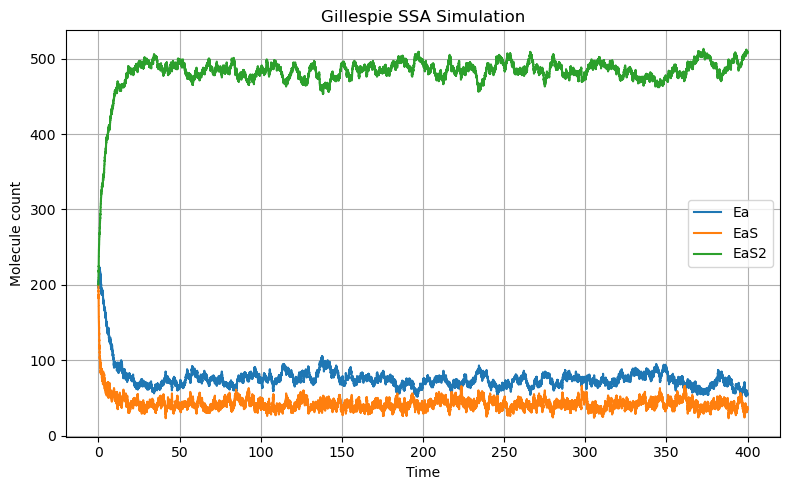

In [14]:
SM = Matrix( [[-1,1,0], [1,-1,-1], [0,0,1], [-1,0,-1], [0,1,0]])

species_names = ["Ea", "EaS","EaS2","S","Na"]

module_for_simulating = ModuleProperties(SM, 3, species_names)

# RunSSA input requiremetns 

initial_counts = [200, 200, 200, 50, 50]

rates = [0.005, 0.02, 0.6, 0.002, 0.012, 0.05]

simulation_length = 400.0
# 


SIM = RunSSA(module_for_simulating, initial_counts, rates, simulation_length)
SIM.run_SSA_and_plot_counts()